# **TO GRANT OR NOT TO GRANT: DECIDING ON COMPENSATION BENEFITS - PART 3: DATA CLEANING AND PRE-PROCESSING**

## 1. Imports and initial transformations

In [2]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from collections import Counter

from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.metrics import classification_report, make_scorer, f1_score, recall_score, precision_score, confusion_matrix, accuracy_score

In [3]:
# setting the options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=np.inf)

In this notebook X and y_encoded will be referent to the Agreement Reached Model. <br>
X_claim and y_claim will be referent to Claim Injury Type Model <br>
<br> <br>
We will only import the training data since we won't make any kaggle submission here

In [4]:
train_dtype_file = 'train_dtypes_visual_exploration.json'
open_ended_file = 'train_data_visual_exploration.csv'

with open(train_dtype_file, 'r') as f:
    dtypes = json.load(f)

dtype_mapping = {}
date_cols = []
for col, dtype in dtypes.items():
    if dtype == 'datetime64[ns]':
        dtype_mapping[col] = 'object'
        date_cols.append(col)
    else:
        dtype_mapping[col] = dtype

df = pd.read_csv(
    open_ended_file,
    sep=',',
    index_col=0,
    dtype=dtype_mapping
)

for date in date_cols:
    df[date] = pd.to_datetime(df[date])


<a class="anchor" id="three-bullet"> 
<d style="color:white;">

### 1.2. Data Cleaning
</a> 
</d>   

As we previously mentioned, there are some columns with weird values:
- **Age at Injury**: multiple values below 14, which is the minimum legal age to work in the USA
- **WCIO Part Of Body Code**: has a negative value

Before we go any further, let's try to tackle these issues.

#### 1.2.1. Age at Injury

In [5]:
df.loc[df['Age at Injury'] < 14, 'Age at Injury'] = np.nan

In [6]:
df.loc[
    (df['Age at Injury'] < 14) & (df['Accident Date'].isna() | df['Birth Year'].isna()), 
    'Age at Injury'
] = np.nan

As discussed in the notebook 'Part1-InitialInspection.ipynb', these values cannot yet be fixed, since we are trying to fix them using mathematical logic. Therefore, we will come back to fixing these values after we perform data imputation on the 'Accident Date' and 'Birth Year' columns. If there still are any inconsistent values in the test data, we will set them as NaN and impute them later.

#### 1.2.2. WCIO Part Of Body Code

In [7]:
len(df[df['WCIO Part Of Body Code'] < 0])

42011

In [8]:
df[df['WCIO Part Of Body Code'] < 0]['WCIO Part Of Body Code'].unique()

<IntegerArray>
[-9]
Length: 1, dtype: Int64

In [9]:
len(df[df['WCIO Part Of Body Code'] == 9])

0

In [10]:
df['WCIO Part Of Body Code'] = np.where(
    # we select only the rows that meet the necessary conditions
    (df['WCIO Part Of Body Code'] < 0) & (df['WCIO Part Of Body Code'].notna()),
    # if conditions are met, we calculate the new value
    df['WCIO Part Of Body Code'].abs(),
    # otherwise, we keep the original value
    df['WCIO Part Of Body Code']
)

In [11]:
len(df[df['WCIO Part Of Body Code'] < 0])

0

<a class="anchor" id="four-bullet"> 
<d style="color:white;">

### 1.3. Missing Values
</a> 
</d>  

In [12]:
# calculate the number of NaNs for each column
nan_counts = df.isna().sum()

# get the total number of rows
total_rows = df.shape[0]

# calculate the percentage of NaN values for each column
percentage_nans = (nan_counts / total_rows) * 100

# format the percentages with '%' sign
percentage_nans = percentage_nans.apply(lambda x: f"{x:.2f}%")

# combine all the information into a DataFrame
nan_summary = pd.DataFrame({
    'NaN Count': nan_counts
    , 'Total Values': [total_rows] * len(nan_counts)
    , 'Percentage NaN': percentage_nans
})

display(nan_summary)

,NaN Count,Total Values,Percentage NaN
Accident Date,3688,574022,0.64%
Age at Injury,5415,574022,0.94%
Alternative Dispute Resolution,0,574022,0.00%
Assembly Date,0,574022,0.00%
Attorney/Representative,0,574022,0.00%
Average Weekly Wage,28651,574022,4.99%
Birth Year,31018,574022,5.40%
C-2 Date,14559,574022,2.54%
C-3 Date,386781,574022,67.38%
Carrier Name,0,574022,0.00%


In [13]:
missing_values = [
    'Accident Date'
    , 'Average Weekly Wage'
    , 'Birth Year'
    #, 'C-2 Date'  # missing form could have relationship with the target
    #, 'C-3 Date'  # missing form could have relationship with the target
    #, 'First Hearing Date'  # missing values means no hearing has held
    , 'Gender'
    #, 'IME-4 Count'  # missing form could have relationship with the target
    , 'Industry Code'
    , 'WCIO Cause of Injury Code'
    , 'WCIO Nature of Injury Code'
    , 'WCIO Part Of Body Code'
    , 'Zip Code'
    , 'Days Difference'
]

<a class="anchor" id="five-bullet"> 
<d style="color:white;">

### 1.4. Simple Encoding
</a> 
</d>  

In [14]:
binary_columns = ['Alternative Dispute Resolution', 'Attorney/Representative', 'Gender', 'COVID-19 Indicator']

In [15]:
for col in binary_columns:
    display(df[col].value_counts())

Alternative Dispute Resolution
N    571408
Y      2609
U         5
Name: count, dtype: int64

Attorney/Representative
N    392291
Y    181731
Name: count, dtype: int64

Gender
M    335216
F    234049
Name: count, dtype: int64

COVID-19 Indicator
N    546504
Y     27518
Name: count, dtype: int64

Before we proceed with the encoding of these features, let us replace the value 'U' in 'Alternative Dispute Resolution', by setting it as NaN

In [16]:
df.loc[df['Alternative Dispute Resolution'] == 'U', 'Alternative Dispute Resolution'] = np.nan

In [17]:
# Encoding binary features
for col in binary_columns:
    df[col] = df[col].map({'Y': 1, 'N': 0, 'M': 1, 'F': 0})

In [18]:
def encode_dates(df, date_columns):
    for col in date_columns:
        df[f'{col}_year'] = df[col].apply(lambda x: x.year if pd.notnull(x) else np.nan)
        df[f'{col}_month'] = df[col].apply(lambda x: x.month if pd.notnull(x) else np.nan)
        df[f'{col}_day'] = df[col].apply(lambda x: x.day if pd.notnull(x) else np.nan)

    # Drop the original date columns
    df.drop(columns=date_columns, inplace=True)

In [19]:
date_features = [
    'Accident Date'
    , 'Assembly Date'
    , 'C-2 Date'
    , 'C-3 Date'
    , 'First Hearing Date'
]

In [20]:
# Apply the transformation
encode_dates(df, date_features)

## Initial Short Inspection for Open Ended Section

It is not necessary to remove rows since Agreement Reached has no null values

In [21]:
df['Agreement Reached'].isnull().sum()

0

Let's analyse the distribution of Agreement Reached

In [22]:
df['Agreement Reached'].value_counts(normalize=True)

Agreement Reached
0    0.953335
1    0.046665
Name: proportion, dtype: Float64

The class distribution is heavily imbalanced, with class "1" representing only a small fraction of the data. As a result, predicting class "1" is likely to be very challenging. Consequently, incorporating this variable into the model predicting Claim Injury Type might not lead to significant improvement, given the low variance in the data - primarily dominated by class "0".

We are going to use XGBoost and the Neural Network we defined to predict Claim Injury Type

## Pipeline

In [23]:
df_claim = df.drop(columns=['Agreement Reached']).copy()

In [24]:
X = df.drop(columns=['Agreement Reached', 'Claim Injury Type'])
y = df['Agreement Reached']

In [25]:
X_claim = df_claim.drop(columns=['Claim Injury Type'])
y_claim = df_claim['Claim Injury Type']

Outliers Treatment - Capping

In [26]:
class ClipOutliersMulti(BaseEstimator, TransformerMixin):
    def __init__(self, quantile_limits=None, fixed_limits=None):
        """
        quantile_limits: dictionary with quantile-based limits. Example:
            {'Age at Injury': (0.01, 0.95), 'Birth Year': (0.01, 0.95)}

        fixed_limits: dictionary with fixed limits. Example:
            {'IME-4 Count': (None, 40)}
        """
        self.quantile_limits = quantile_limits or {}
        self.fixed_limits = fixed_limits or {}
        self.bounds = {}

    def fit(self, X, y=None):
        # Calculate limits based on quantiles
        for col, (q_lower, q_upper) in self.quantile_limits.items():
            self.bounds[col] = {
                'lower': X[col].quantile(q_lower) if q_lower is not None else None,
                'upper': X[col].quantile(q_upper) if q_upper is not None else None
            }

        # Add fixed limits
        for col, (lower, upper) in self.fixed_limits.items():
            self.bounds[col] = {
                'lower': lower,
                'upper': upper
            }
        return self

    def transform(self, X):
        # Clip values based on the calculated or fixed bounds
        X = X.copy()
        for col, limits in self.bounds.items():
            X[col] = X[col].astype(float).clip(lower=limits['lower'], upper=limits['upper'])
        return X

Frequency Encoder

In [27]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        """
        columns: List of categorical columns to apply frequency encoding.
        """
        self.columns = columns
        self.freq_encodings = {}

    def fit(self, X, y=None):
        # Check if X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("FrequencyEncoder requires a pandas DataFrame as input.")
        
        # Calculate frequency encoding for each column
        for col in self.columns:
            if col not in X.columns:
                raise ValueError(f"Column '{col}' not found in input DataFrame.")
            # Only normalized values (removes named indexes)
            self.freq_encodings[col] = X[col].value_counts(normalize=True).to_dict()
        
        return self

    def transform(self, X):
        # Check if X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("FrequencyEncoder requires a pandas DataFrame as input.")
        
        X = X.copy()
        # Apply frequency mapping
        for col in self.columns:
            if col in X.columns:
                X[col] = X[col].map(self.freq_encodings[col]).fillna(0)  # Fill non-mapped values with 0
        
        return X


Target Encoding

adding open ended encoder

In [28]:
# Encoder for the target variable
target_encoder = OrdinalEncoder()

# Encoder for the target variable
y_encoded = target_encoder.fit_transform(y.to_numpy().reshape(-1, 1)).flatten()
y_claim = target_encoder.fit_transform(y_claim.to_numpy().reshape(-1, 1)).flatten()


Scalling and One-Hot Encoding

In [29]:
scaling_features = [
    'Age at Injury',
    'Average Weekly Wage',
    'Birth Year',
    'IME-4 Count',
    #'Industry Code',
    #'WCIO Cause of Injury Code',
    #'WCIO Nature of Injury Code',
    #'WCIO Part Of Body Code',
    'Number of Dependents',
    'Days Difference',
    'Accident Date_year', 'Accident Date_month', 'Accident Date_day',
    'Assembly Date_year', 'Assembly Date_month', 'Assembly Date_day',
    'C-2 Date_year', 'C-2 Date_month', 'C-2 Date_day',
    'C-3 Date_year', 'C-3 Date_month', 'C-3 Date_day',
    'First Hearing Date_year', 'First Hearing Date_month', 'First Hearing Date_day'
]

# List of features for One-Hot encoding
lowcard_features = ['Carrier Type', 'District Name', 'Medical Fee Region']

# Set up the preprocessor with scaling and OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), scaling_features),  # Apply scaling to the specified features
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), lowcard_features)  # Apply One-Hot encoding to low-cardinality features
    ],
    remainder='passthrough',  # Keep columns not specified
    verbose_feature_names_out=False  # Do not rename the columns
).set_output(transform="pandas")  # Ensure the output is a DataFrame

Missing Values Imputation - KNN

In [30]:
class SampleKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features, n_neighbors=5, weights='distance', sample_size=30000, random_state=20):
        """
        features: List of columns to be imputed.
        n_neighbors: Number of neighbors for the KNNImputer.
        sample_size: Number of samples for fitting the imputer.
        random_state: Random seed for sampling control.
        """
        self.features = features
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.sample_size = sample_size
        self.random_state = random_state
        self.imputer = KNNImputer(n_neighbors=self.n_neighbors, weights=self.weights)

    def fit(self, X, y=None):
        # Rebuild DataFrame if X is a NumPy array
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.features)

        # Select a sample to fit the imputer
        sample = X[self.features].sample(n=self.sample_size, random_state=self.random_state)
        self.imputer.fit(sample)
        
        return self

    def transform(self, X):
        # Rebuild DataFrame if X is a NumPy array
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.features)

        # Impute missing values
        X[self.features] = self.imputer.transform(X[self.features])
        
        return X

Missing Values Imputation - Zero Fill

In [31]:
class ZeroFillImputer(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        """
        features: List of columns that should be filled with zero.
        """
        self.features = features

    def fit(self, X, y=None):
        # No fitting logic is required
        return self

    def transform(self, X):
        X = X.copy()
        X[self.features] = X[self.features].fillna(0)
        
        return X

Imputer Grid Search

In [32]:
class ImputerGridSearch:
    def __init__(self, pipeline, imputer_param_grid, random_state=20):
        """
        Initializes the ImputerGridSearch object.
        
        pipeline: The pipeline that includes the imputer and other steps.
        imputer_param_grid: Dictionary containing the parameter grid for the imputer.
        random_state: Random seed for reproducibility (default is 20).
        """
        self.pipeline = pipeline
        self.imputer_param_grid = imputer_param_grid
        self.random_state = random_state

    def perform_grid_search(self, data, cv, y):
        """
        Perform grid search on the pipeline with the imputer parameters.
        
        data: The input data for training.
        cv: Cross-validation strategy (KFold).
        y: The target variable (labels).
        
        Returns the best model found during grid search.
        """
        best_params = None
        best_score = float('-inf')

        # Define the parameter grid for the imputer step in the pipeline
        param_grid = {
            'imputer__n_neighbors': self.imputer_param_grid['n_neighbors'],  # Number of neighbors for KNN
            'imputer__weights': self.imputer_param_grid['weights']  # Weights for KNN imputation
        }

        # Set up GridSearchCV to search for the best hyperparameters
        grid_search = GridSearchCV(
            self.pipeline,  # The pipeline to be optimized
            param_grid,  # The parameter grid to search
            scoring='f1_macro',  # Evaluate using F1 score (macro average)
            cv=cv,  # Cross-validation strategy
            verbose=3,  # Display detailed information during the search
            n_jobs=-1  # Use all available CPU cores
        )

        # Perform grid search
        grid_search.fit(data, y)

        # Store the best parameters and best score found
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        # Print the results of the grid search
        print(f"Best Parameters: {best_params}")
        print(f"Best Test Score: {best_score:.4f}")

        # Return the pipeline with the best parameters
        return self.pipeline


<a class="anchor" id="seven-bullet"> 
<d style="color:white;">

## 2. Feature Selection
</a> 
</d>   

<a class="anchor" id="eight-bullet"> 
<d style="color:white;">

### 2.1. Spearman Correlation
</a> 
</d>  

In [33]:
class RemoveHighSpearmanCorrelation(BaseEstimator, TransformerMixin):
    def __init__(self, features, threshold=0.8):
        """
        Remove highly correlated variables based on Spearman correlation.

        Parameters:
        - features: List of numeric variables to be analyzed.
        - threshold: Limit above which variables will be considered correlated.
        """
        self.features = features
        self.threshold = threshold
        self.to_remove = []


    def fit(self, X, y=None):
        """
        Calculates the correlation and identifies the variables to be removed.

        Parameters:
        - X: Input DataFrame.
        - y: Ignored (for compatibility with sklearn).
        """
        # Calculate the correlation matrix for the specified variables
        corr_matrix = X[self.features].corr(method='spearman')
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

        # Identify variables with high correlation
        self.to_remove = [
            column for column in upper_triangle.columns 
            if any(upper_triangle[column] > self.threshold)
        ]

        return self


    def transform(self, X):
        """
        Removes the identified variables.

        """
        return X.drop(columns=self.to_remove, errors='ignore')

<a class="anchor" id="nine-bullet"> 
<d style="color:white;">

### 2.2. XGBoost
</a> 
</d>  

In [34]:
class XGBFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, num_features=18, model=None, random_state=42):
        """
        num_features: Number of most important features to select.
        model: Model to be used for calculating feature importance.
        random_state: Seed for reproducibility.
        """
        self.num_features = num_features
        self.model = model if model else XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            scale_pos_weight=1,
            random_state=random_state,
            use_label_encoder=False,
            eval_metric='mlogloss'
        )
        self.random_state = random_state  # Adds random_state as an internal attribute
        self.top_features = None

    def fit(self, X, y):
        # Fit the model to calculate feature importance
        self.model.fit(X, y)
        # Select the N most important features
        feature_importances = pd.Series(self.model.feature_importances_, index=X.columns)
        self.top_features = feature_importances.nlargest(self.num_features).index
        
        return self

    def transform(self, X):
        # Return only the selected features
        return X[self.top_features]


<a class="anchor" id="ten-bullet"> 
<d style="color:white;">

### 2.3. Decision Trees
</a> 
</d>  

Feature selection with Decision Trees. By using the module __.feature_importances___ we can calculate the feature importance using the split criteria 'gini' and 'entropy'

In [35]:
class DT_FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, gini_threshold=0.005, entropy_threshold=0.005, random_state=42):
        """
        num_features: Maximum number of features to select.
        gini_threshold: Minimum importance threshold for the Gini criterion.
        entropy_threshold: Minimum importance threshold for the Entropy criterion.
        random_state: Seed for reproducibility.
        """
        
        self.gini_threshold = gini_threshold
        self.entropy_threshold = entropy_threshold
        self.random_state = random_state
        self.top_features = None

    def fit(self, X, y):
        # Model with Gini criterion
        gini_model = DecisionTreeClassifier(criterion='gini', random_state=self.random_state)
        gini_model.fit(X, y)
        gini_importance = pd.Series(gini_model.feature_importances_, index=X.columns)
        
        # Model with Entropy criterion
        entropy_model = DecisionTreeClassifier(criterion='entropy', random_state=self.random_state)
        entropy_model.fit(X, y)
        entropy_importance = pd.Series(entropy_model.feature_importances_, index=X.columns)

        # Combine the importances into a DataFrame
        feature_importances = pd.DataFrame({
            'gini': gini_importance,
            'entropy': entropy_importance
        })

        # Melt the DataFrame to long format and filter based on the thresholds
        feature_importances['feature'] = X.columns
        tidy = feature_importances.melt(id_vars='feature', var_name='criterion', value_name='importance')
        tidy = tidy[tidy['importance'] > 0]  # Remove zero importances

        # Filter features that pass the thresholds
        selected_features = tidy[((tidy['criterion'] == 'gini') & (tidy['importance'] > self.gini_threshold)) |
                                  ((tidy['criterion'] == 'entropy') & (tidy['importance'] > self.entropy_threshold))]

        # Sort by importance and select the N best features
        selected_features = selected_features.sort_values(by='importance', ascending=False)
        self.top_features = selected_features['feature'].unique()

        return self

    def transform(self, X):
        # Return only the selected features
        if self.top_features is None:
            raise RuntimeError("The fit method needs to be called before transform.")
        return X[self.top_features]

<a class="anchor" id="twelve-bullet"> 
<d style="color:white;">

## 3. Model Assessment
</a> 
</d>   

<a class="anchor" id="thirteen-bullet"> 
<d style="color:white;">

### 3.1. Pre Model 
</a> 
</d>  

In [36]:
def ensure_dataframe(X):
    # Ensures that the input is a pandas DataFrame; if not, converts it to one
    if not isinstance(X, pd.DataFrame):
        return pd.DataFrame(X)
    
    return X


In [37]:
def inspect_columns(X):
    # Prints the list of columns after preprocessing
    print(f"Columns after preprocessor: {list(X.columns)}")
    return X

In [38]:
code_mapping = {
    'Industry Code': {
        'Primary Industry': [11, 21, 22]  # Raw materials
        ,'Secondary Industry': [23, 31]  # Manufacturing and Production
        ,'Tertiary Industry': [42, 44, 48, 53]  # Services
        ,'Quaternary Industry': [51, 52, 54, 55]  # Knowledge-based
        ,'Social and Public Services': [61, 62, 92]
        ,'Recreational and Hospitality Services': [71, 72]
        ,'Other Services': [56, 81]
    }
    ,'WCIO Part Of Body Code': {
        'Head': range(10, 20)
        ,'Neck': range(20, 27)
        ,'Upper Extremities': range(30, 40)
        ,'Trunk': [*range(40, 50), *range(60, 64)]
        ,'Lower Extremities': range(50, 59)
        ,'Multiple Body Parts': [9, *range(64, 67), 90, 91, 99]
    }
    ,'WCIO Nature of Injury Code': {
        'Specific Injury': [1, 2, 3, 4, 7, 10, 13, 16, 19, 22, 25, 28, 30, 31, 32, 34, 36, 37, 38, 40, 41, 42, 43, 46, 47, 49, 52, 53, 54, 55, 58, 59]
        ,'Occupational Disease or Cumulative Injury': [*range(60, 81), 83]
        ,'Multiple Injuries': [90, 91]
    }
    ,'WCIO Cause of Injury Code': {
        'Burn or Scald - Heat or Cold Exposures - Contact With': [*range(1, 10), 11, 14, 84]
        ,'Caught In, Under or Between': [10, 12, 13, 20]
        ,'Cut, Puncture, Scrape Injured By': range(15, 20)
        ,'Fall, Slip or Trip Injury': range(25, 34)
        ,'Motor Vehicle': [40, 41, *range(45, 49), 50]
        ,'Strain or Injury By': [*range(52, 62), 97]
        ,'Stricking Against or Stepping On': range(65, 71)
        ,'Struck or Injured By': [*range(74, 82), 85, 86]
        ,'Rubbed or Abraded By': [94, 95]
        ,'Miscellaneous Causes': [82, 83, *range(87, 92), 93, 96, 98, 99]
    }    
}

Mappings Reference:
- https://www.dir.ca.gov/dwc/WCIS/Part_of_Body.pdf
- https://www.dir.ca.gov/dwc/WCIS/Nature_Of_Injury.pdf
- https://www.dir.ca.gov/dwc/WCIS/Cause_Of_Injury.pdf

In [39]:
class CodeMapper(BaseEstimator, TransformerMixin):
    def __init__(self, mapping_dict):
        """
        Initializes the CodeMapper with a dictionary containing the mapping information.
        """
        self.mapping_dict = mapping_dict


    def fit(self, X, y=None):
        return self
    

    def transform(self, X):
        """
        Transforms the input data by applying the specified mappings to the relevant columns.
        """
        X_transformed = X.copy()

        # Loop through the columns and apply the reverse mappings
        for col, mappings in self.mapping_dict.items():
            # Reverse the mapping to map values to their corresponding keys
            reverse_mapping = {
                val: key 
                for key, values in mappings.items() 
                for val in values
            }

            # Apply the mapping to the column and keep the original value if no mapping is found
            X_transformed[col] = X_transformed[col].map(reverse_mapping).fillna(X_transformed[col])

        return X_transformed


In [40]:
class ConvertDataType(BaseEstimator, TransformerMixin):
    def __init__(self, dtype, columns):
        """
        Initializes the transformer to change the data type of specified columns.
        """
        self.dtype = dtype
        self.columns = columns


    def fit(self, X, y=None):
        return self
    

    def transform(self, X):
        """
        Transforms the data by converting specified columns to the target data type.
        """
        X = X.copy()

        for col in self.columns:
            X[col] = X[col].astype(self.dtype)

        return X


In [41]:
class FixCodes(BaseEstimator, TransformerMixin):
    def __init__(self, valid_codes, columns):
        """
        Initializes the transformer to fix codes based on the closest valid value.
        """
        self.valid_codes = valid_codes
        self.columns = columns


    def fit(self, X, y=None):
        return self
    

    def transform(self, X):
        """
        Transforms the data by replacing invalid codes with the closest valid value.
        """
        def closest_valid_value(col, val):
            """
            Finds the closest valid value for a given invalid code.
            """
            valid_values = []

            for category, values in self.valid_codes[col].items():
                valid_values.extend(values)

            if val in valid_values:
                return val
            else:
                return min(valid_values, key=lambda x: abs(x - val))
            

        X_transformed = X.copy()

        for col in self.columns:
            X_transformed[col] = X[col].apply(lambda x: closest_valid_value(col, x))

        return X_transformed


In [42]:
# inicializing kf with StratifiedKFold that will be used in the rest of the notebook
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [43]:
def evaluate_feature_intervals(pipeline, X, y, feature_intervals, scoring='f1_macro', cv=5):
    """
    Evaluates different numbers of features in the pipeline using Stratified K-Fold CV.
    
    Parameters:
    - pipeline: Sklearn pipeline with EmbeddedFeatureSelector.
    - X: DataFrame of features.
    - y: Target variable.
    - feature_intervals: List of numbers of features to test.
    - scoring: Evaluation metric (default: 'f1_macro').
    - cv: Number of folds for cross-validation.
    
    Returns:
    - DataFrame with the results (n_features, mean_train_score, mean_val_score, overfit).
    """
    results = []
    
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    for num_features in feature_intervals:
        # Update the number of features in the selector within the pipeline
        pipeline.set_params(feature_selector__num_features=num_features)
        
        # Perform cross-validation with StratifiedKFold
        scores = cross_validate(
            pipeline, X, y, cv=skf, scoring=scoring, n_jobs=-1, return_train_score=True
        )
        
        # Store the results
        results.append({
            'n_features': num_features,
            'mean_train_score': scores['train_score'].mean(),
            'mean_val_score': scores['test_score'].mean(),
            'overfit': abs(scores['train_score'].mean() - scores['test_score'].mean())
        })
    
    return pd.DataFrame(results)


In [44]:
def avg_score(model, X, y):
    """
    This function receives a model, the X and y data, and applies cross-validation
    using StratifiedKFold to calculate the F1 score for both training and validation.
    """
    
    # Lists to store the results of time and F1 score
    train_f1_scores = []
    val_f1_scores = []

    # Loop through the StratifiedKFold splits
    for train_index, val_index in kf.split(X, y):
        # Get the training and validation data for each split
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        
        # Train the model on the training data
        model.fit(X_train_fold, y_train_fold)

        # Calculate the F1-score for the training data
        train_predictions = model.predict(X_train_fold)
        train_f1 = f1_score(y_train_fold, train_predictions, average='macro')  # Adjusted for multiclass
        
        # Calculate the F1-score for the validation data
        val_predictions = model.predict(X_val_fold)
        val_f1 = f1_score(y_val_fold, val_predictions, average='macro')  # Adjusted for multiclass
        
        # Store the results in the lists
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

    # Calculate the averages of each metric
    avg_train_f1 = np.mean(train_f1_scores)
    avg_val_f1 = np.mean(val_f1_scores)

    # Return the results formatted
    return avg_train_f1, avg_val_f1


def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # For each model passed as an argument
    for arg in args:
        # Obtain the results provided by avg_score
        avg_train, avg_val = avg_score(arg, X, pd.DataFrame(y_encoded))
        # Store the results in the correct row
        df.iloc[count] = avg_train, avg_val
        count+=1
    return df


In [45]:
preproc_steps = [
    ('clip_outliers', ClipOutliersMulti(
            quantile_limits={
                'Age at Injury': (0.01, 0.95),
                'Average Weekly Wage': (None, 0.75),  
                'Birth Year': (0.01, 0.95),
                'Days Difference': (None, 0.80),
            },
            fixed_limits={
                'IME-4 Count': (None, 40)
            }
        )),
        ('preprocessor', preprocessor),  #Scalling and one hot encoding
        ('frequency_encoder', FrequencyEncoder(columns=[
            'Carrier Name', 'County of Injury', 'Zip Code'
        ])),
        ('imputer', SampleKNNImputer(
            features=[
                'Alternative Dispute Resolution', 'Average Weekly Wage', 'Age at Injury', 'Birth Year', 'Carrier Name', 'Gender',
                'Zip Code', 'Accident Date_year', 'Accident Date_month', 'Accident Date_day', 'Days Difference',
                'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code',
                'C-2 Missed Timing', 'C-3 Missed Timing', 'Log Average Weekly Wage', 'Log Birth Year', 'Log IME-4 Count'
            ],
            n_neighbors=5, weights='uniform', sample_size=1000, random_state=20
        )),
        ('int_convert', ConvertDataType(dtype='int', columns=['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'])),
        ('fix_codes', FixCodes(valid_codes=code_mapping, columns=['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'])),
        ('zero_fill', ZeroFillImputer(features=[
            'IME-4 Count', 'C-2 Date_year', 'C-2 Date_month', 'C-2 Date_day',
            'C-3 Date_year', 'C-3 Date_month', 'C-3 Date_day',
            'First Hearing Date_year', 'First Hearing Date_month', 'First Hearing Date_day'
        ])),
        ('code_mapping', CodeMapper(code_mapping)),
        ('oh_codes', ColumnTransformer(transformers=[
            ('onehot', OneHotEncoder(
                sparse_output=False
                ,handle_unknown='ignore'
                ,drop='first'
            ), ['Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'])
        ], remainder='passthrough'  # Preserve unspecified columns
        ,verbose_feature_names_out=False  # Do not rename columns
        ).set_output(transform="pandas"))
]

<a class="anchor" id="fourteen-bullet"> 
<d style="color:white;">

### 3.2. XGBoost
</a> 
</d>  

#### 3.2.1. Pipeline Construction with XGBoost

In [46]:
pipeline_XGB = Pipeline(steps=[
    *preproc_steps,
    ('feature_selector', XGBFeatureSelector(num_features=53)),  # Feature Selection
    ('model', XGBClassifier(  # Final Model
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        reg_alpha=5,
        reg_lambda=10,
        random_state=42,
    ))
])

#### 3.2.2. Confusion Matrix

c:\Users\rodri\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:38:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


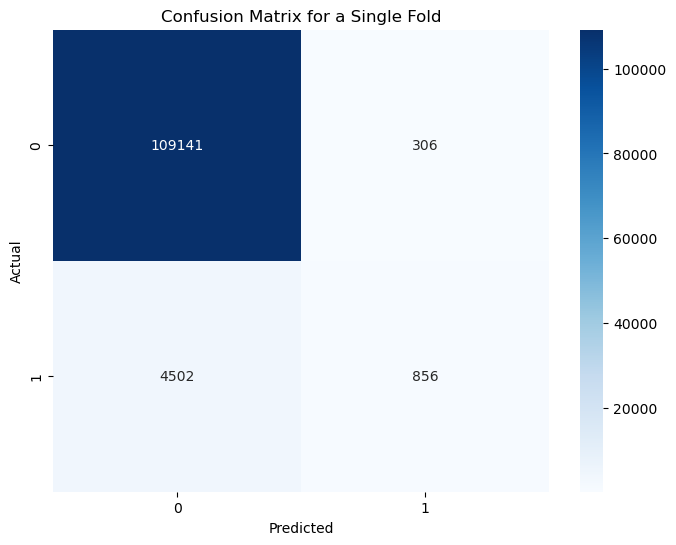

In [53]:
# Select the first fold
for train_idx, val_idx in kf.split(X, y_encoded):
    # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
    
    # Fit the pipeline on the training fold
    pipeline_XGB.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_val_pred = pipeline_XGB.predict(X_val)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    
    # Display the matrix graphically
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=pipeline_XGB.classes_, yticklabels=pipeline_XGB.classes_)
    plt.title("Confusion Matrix for a Single Fold")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    
    break

As expected, we predict most observations of the class "1" wrongly. We end up with mostly the class 0 on our data which won't add much variance and therefore will probably not increase the performance of the model that predicts Claim Injury Type.

#### 3.2.3. F1-Macro, Recall-Macro and Precision-Macro

In [128]:
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro')
}

cv_results = cross_validate(
    pipeline_XGB,
    X,
    y_encoded,
    cv=kf,
    scoring=scoring,
    return_train_score=True
)

# F1-Macro
train_f1_scores = cv_results['train_f1_macro']
val_f1_scores = cv_results['test_f1_macro']
print("Train F1-Macro scores for each fold:", train_f1_scores)
print("Validation F1-Macro scores for each fold:", val_f1_scores)
print("Mean Train F1-Macro score:", train_f1_scores.mean())
print("Mean Validation F1-Macro score:", val_f1_scores.mean())
print("Std Dev Train F1-Macro score:", train_f1_scores.std())
print("Std Dev Validation F1-Macro score:", val_f1_scores.std())

# Recall-Macro
train_recall_scores = cv_results['train_recall_macro']
val_recall_scores = cv_results['test_recall_macro']
print("\nMean Train Recall-Macro score:", train_recall_scores.mean())
print("Mean Validation Recall-Macro score:", val_recall_scores.mean())
print("Std Dev Train Recall-Macro score:", train_recall_scores.std())
print("Std Dev Validation Recall-Macro score:", val_recall_scores.std())

# Precision-Macro
train_precision_scores = cv_results['train_precision_macro']
val_precision_scores = cv_results['test_precision_macro']
print("\nMean Train Precision-Macro score:", train_precision_scores.mean())
print("Mean Validation Precision-Macro score:", val_precision_scores.mean())
print("Std Dev Train Precision-Macro score:", train_precision_scores.std())
print("Std Dev Validation Precision-Macro score:", val_precision_scores.std())

c:\Users\rodri\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:52:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\rodri\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:53:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\rodri\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\rodri\anaconda3\Lib\site-packages\

Train F1-Macro scores for each fold: [0.62125583 0.62322639 0.62283129 0.62327805 0.62317116]
Validation F1-Macro scores for each fold: [0.62051242 0.61434134 0.61023074 0.60435814 0.60823369]
Mean Train F1-Macro score: 0.6227525424438307
Mean Validation F1-Macro score: 0.6115352672142343
Std Dev Train F1-Macro score: 0.0007644982664632306
Std Dev Validation F1-Macro score: 0.005524070679419396

Mean Train Recall-Macro score: 0.579779619726905
Mean Validation Recall-Macro score: 0.5726761798781181
Std Dev Train Recall-Macro score: 0.0005783824641064821
Std Dev Validation Recall-Macro score: 0.003656324347138244

Mean Train Precision-Macro score: 0.857243901814537
Mean Validation Precision-Macro score: 0.8310890316660352
Std Dev Train Precision-Macro score: 0.0018736536391499182
Std Dev Validation Precision-Macro score: 0.010072885053849704


<a class="anchor" id="fifteen-bullet"> 
<d style="color:white;">

### 3.3. Neural Network
</a> 
</d>  

In [55]:
pipeline_NN = Pipeline(steps=[
    *preproc_steps,
    ('select_k_best', SelectKBest(k=44, score_func=f_classif)),
    ('final_model', MLPClassifier(
        hidden_layer_sizes=(250, 120)
        ,batch_size=500
        ,max_iter=400
        ,random_state=20
        ,learning_rate='constant'
        ,learning_rate_init=0.1
        ,solver='sgd'
    ))
])

#### 3.3.1. Confusion Matrix

c:\Users\rodri\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


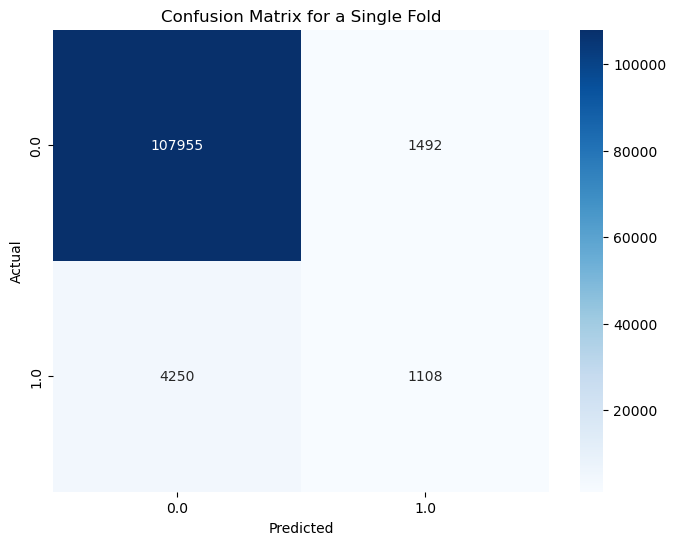

In [56]:
# Select the first fold
for train_idx, val_idx in kf.split(X, y_encoded):
    # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
    
    # Fit the pipeline on the training fold
    pipeline_NN.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_val_pred = pipeline_NN.predict(X_val)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    
    # Display the matrix graphically
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=pipeline_NN.classes_, yticklabels=pipeline_NN.classes_)
    plt.title("Confusion Matrix for a Single Fold")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    
    break


#### 3.3.2. F1-Macro, Recall-Macro and Precision-Macro

In [57]:
cv_results = cross_validate(
    pipeline_NN,
    X,
    y_encoded,
    cv=kf,
    scoring=scoring,
    return_train_score=True
)

# F1-Macro
train_f1_scores = cv_results['train_f1_macro']
val_f1_scores = cv_results['test_f1_macro']
print("Train F1-Macro scores for each fold:", train_f1_scores)
print("Validation F1-Macro scores for each fold:", val_f1_scores)
print("Mean Train F1-Macro score:", train_f1_scores.mean())
print("Mean Validation F1-Macro score:", val_f1_scores.mean())
print("Std Dev Train F1-Macro score:", train_f1_scores.std())
print("Std Dev Validation F1-Macro score:", val_f1_scores.std())

# Recall-Macro
train_recall_scores = cv_results['train_recall_macro']
val_recall_scores = cv_results['test_recall_macro']
print("\nMean Train Recall-Macro score:", train_recall_scores.mean())
print("Mean Validation Recall-Macro score:", val_recall_scores.mean())
print("Std Dev Train Recall-Macro score:", train_recall_scores.std())
print("Std Dev Validation Recall-Macro score:", val_recall_scores.std())

# Precision-Macro
train_precision_scores = cv_results['train_precision_macro']
val_precision_scores = cv_results['test_precision_macro']
print("\nMean Train Precision-Macro score:", train_precision_scores.mean())
print("Mean Validation Precision-Macro score:", val_precision_scores.mean())
print("Std Dev Train Precision-Macro score:", train_precision_scores.std())
print("Std Dev Validation Precision-Macro score:", val_precision_scores.std())

c:\Users\rodri\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rodri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train F1-Macro scores for each fold: [0.71749909 0.55649487 0.56266856 0.59968491 0.48805471]
Validation F1-Macro scores for each fold: [0.62627823 0.55385486 0.56024206 0.59209301 0.48805579]
Mean Train F1-Macro score: 0.5848804269424013
Mean Validation F1-Macro score: 0.5641047905771811
Std Dev Train F1-Macro score: 0.07547345144217125
Std Dev Validation F1-Macro score: 0.04593976109652035

Mean Train Recall-Macro score: 0.5613584013635754
Mean Validation Recall-Macro score: 0.546182921704505
Std Dev Train Recall-Macro score: 0.055664787373571764
Std Dev Validation Recall-Macro score: 0.03175290710017786

Mean Train Precision-Macro score: 0.7676604994379763
Mean Validation Precision-Macro score: 0.7308778952042444
Std Dev Train Precision-Macro score: 0.14725068236944902
Std Dev Validation Precision-Macro score: 0.13858290868341924


c:\Users\rodri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<a class="anchor" id="sixteen-bullet"> 
<d style="color:white;">

### 3.4. Logistic Regression
</a> 
</d>  

In [54]:
pipeline_LR = Pipeline(steps=[
    *preproc_steps,
    ('model', LogisticRegression(
            random_state=42,
            max_iter=1000,
            C = 100,
            l1_ratio = 0.2,
            penalty = 'l2',
            solver = 'newton-cg'))
])

#### 3.4.1. Confusion Matrix

c:\Users\rodri\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


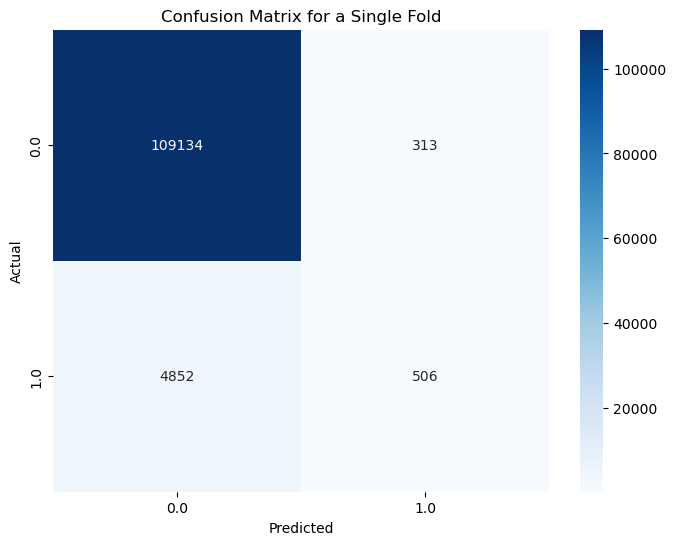

In [55]:
# Select the first fold
for train_idx, val_idx in kf.split(X, y_encoded):
    # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]
    
    # Fit the pipeline on the training fold
    pipeline_LR.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_val_pred = pipeline_LR.predict(X_val)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    
    # Display the matrix graphically
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=pipeline_LR.classes_, yticklabels=pipeline_LR.classes_)
    plt.title("Confusion Matrix for a Single Fold")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    
    break

#### 3.4.2. F1-Macro, Recall-Macro and Precision-Macro

In [56]:
cv_results = cross_validate(
    pipeline_LR,
    X,
    y_encoded,
    cv=kf,
    scoring=scoring,
    return_train_score=True
)

# F1-Macro
train_f1_scores = cv_results['train_f1_macro']
val_f1_scores = cv_results['test_f1_macro']
print("Train F1-Macro scores for each fold:", train_f1_scores)
print("Validation F1-Macro scores for each fold:", val_f1_scores)
print("Mean Train F1-Macro score:", train_f1_scores.mean())
print("Mean Validation F1-Macro score:", val_f1_scores.mean())
print("Std Dev Train F1-Macro score:", train_f1_scores.std())
print("Std Dev Validation F1-Macro score:", val_f1_scores.std())

# Recall-Macro
train_recall_scores = cv_results['train_recall_macro']
val_recall_scores = cv_results['test_recall_macro']
print("\nMean Train Recall-Macro score:", train_recall_scores.mean())
print("Mean Validation Recall-Macro score:", val_recall_scores.mean())
print("Std Dev Train Recall-Macro score:", train_recall_scores.std())
print("Std Dev Validation Recall-Macro score:", val_recall_scores.std())

# Precision-Macro
train_precision_scores = cv_results['train_precision_macro']
val_precision_scores = cv_results['test_precision_macro']
print("\nMean Train Precision-Macro score:", train_precision_scores.mean())
print("Mean Validation Precision-Macro score:", val_precision_scores.mean())
print("Std Dev Train Precision-Macro score:", train_precision_scores.std())
print("Std Dev Validation Precision-Macro score:", val_precision_scores.std())

c:\Users\rodri\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\rodri\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\rodri\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\rodri\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\rodri\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Train F1-Macro scores for each fold: [0.57045531 0.57053796 0.57094861 0.57216059 0.57133669]
Validation F1-Macro scores for each fold: [0.57035851 0.57378581 0.57575209 0.56649096 0.56811875]
Mean Train F1-Macro score: 0.5710878346519765
Mean Validation F1-Macro score: 0.5709012261392065
Std Dev Train F1-Macro score: 0.0006220235995071036
Std Dev Validation F1-Macro score: 0.0034449647492651547

Mean Train Recall-Macro score: 0.546419458805043
Mean Validation Recall-Macro score: 0.546340576169563
Std Dev Train Recall-Macro score: 0.0003758443193466041
Std Dev Validation Recall-Macro score: 0.0022102938720743315

Mean Train Precision-Macro score: 0.7770544115725718
Mean Validation Precision-Macro score: 0.7752899658400831
Std Dev Train Precision-Macro score: 0.0019495869828813368
Std Dev Validation Precision-Macro score: 0.007324617277892992


## Out-of-Fold Predictions for Agreement Reached 

We are going to use XGBoost as the model to make the final prediction and incorporate them as a new variable since it was the model where we got the best scores

In [47]:
oof_predictions = np.zeros(len(X))  # Placeholder para previsões OOF

# Loop para validação cruzada
for train_idx, val_idx in kf.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Treinar a pipeline no fold de treino
    pipeline_XGB.fit(X_train, y_train)
    
    # Fazer previsões no fold de validação
    oof_predictions[val_idx] = pipeline_XGB.predict(X_val)

# Adicionar as previsões OOF ao X como nova variável AO X_claim - we can do this because X and X_claim have the same lines
X_claim['agreement_pred'] = oof_predictions



c:\Users\rodri\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\rodri\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:03:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\rodri\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:04:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\rodri\anaconda3\Lib\site-packages\

In [48]:
X_claim['agreement_pred']

5393875    0.0
5393091    0.0
5393889    0.0
5393887    0.0
5393863    0.0
          ... 
6165265    0.0
6165285    0.0
6165506    0.0
6165339    0.0
6165075    0.0
Name: agreement_pred, Length: 574022, dtype: float64

## Claim Injury Type predictions with Agreement Reached incorporated

Pipeline for CLaim Injury Type Model - Preprocess the same

In [49]:
pipeline_claim = pipeline_XGB


### F1-Macro, Recall-Macro and Precision-Macro

In [51]:
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'precision_macro': make_scorer(precision_score, average='macro')
}

In [52]:
cv_results = cross_validate(
    pipeline_claim,
    X_claim,
    y_claim,
    cv=kf,
    scoring=scoring,
    return_train_score=True
)

# F1-Macro
train_f1_scores = cv_results['train_f1_macro']
val_f1_scores = cv_results['test_f1_macro']
print("Train F1-Macro scores for each fold:", train_f1_scores)
print("Validation F1-Macro scores for each fold:", val_f1_scores)
print("Mean Train F1-Macro score:", train_f1_scores.mean())
print("Mean Validation F1-Macro score:", val_f1_scores.mean())
print("Std Dev Train F1-Macro score:", train_f1_scores.std())
print("Std Dev Validation F1-Macro score:", val_f1_scores.std())

# Recall-Macro
train_recall_scores = cv_results['train_recall_macro']
val_recall_scores = cv_results['test_recall_macro']
print("\nMean Train Recall-Macro score:", train_recall_scores.mean())
print("Mean Validation Recall-Macro score:", val_recall_scores.mean())
print("Std Dev Train Recall-Macro score:", train_recall_scores.std())
print("Std Dev Validation Recall-Macro score:", val_recall_scores.std())

# Precision-Macro
train_precision_scores = cv_results['train_precision_macro']
val_precision_scores = cv_results['test_precision_macro']
print("\nMean Train Precision-Macro score:", train_precision_scores.mean())
print("Mean Validation Precision-Macro score:", val_precision_scores.mean())
print("Std Dev Train Precision-Macro score:", train_precision_scores.std())
print("Std Dev Validation Precision-Macro score:", val_precision_scores.std())

c:\Users\rodri\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:23:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\rodri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rodri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rodri\anacon

Train F1-Macro scores for each fold: [0.45552687 0.45155853 0.45590234 0.45182936 0.45343016]
Validation F1-Macro scores for each fold: [0.42101603 0.44083806 0.4297481  0.4409151  0.43356671]
Mean Train F1-Macro score: 0.45364945164552567
Mean Validation F1-Macro score: 0.4332167983137703
Std Dev Train F1-Macro score: 0.0018073726016164934
Std Dev Validation F1-Macro score: 0.007461375467003494

Mean Train Recall-Macro score: 0.4316793688713124
Mean Validation Recall-Macro score: 0.41470906730687807
Std Dev Train Recall-Macro score: 0.0019670462205855273
Std Dev Validation Recall-Macro score: 0.007173978321598292

Mean Train Precision-Macro score: 0.6005228768541856
Mean Validation Precision-Macro score: 0.547036067707179
Std Dev Train Precision-Macro score: 0.009919397598653125
Std Dev Validation Precision-Macro score: 0.019963767868694728


c:\Users\rodri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Feature  - analysing where agreement_pred is

In [53]:
# Process only the first fold and extract important features
features_first_fold = None

# Process only the first fold and extract important features
for fold, (train_idx, val_idx) in enumerate(kf.split(X_claim, y_claim)):
    # Split the data into training and validation sets
    X_train, X_val = X_claim.iloc[train_idx], X_claim.iloc[val_idx]
    y_train, y_val = y_claim[train_idx], y_claim[val_idx]

    # Fit the pipeline on the training set
    pipeline_XGB.fit(X_train, y_train)

    # Extract the feature selector and model from the pipeline
    feature_selector = pipeline_XGB.named_steps['feature_selector']
    model = pipeline_XGB.named_steps['model']

    # Get selected feature names from the feature selector
    selected_feature_names = feature_selector.top_features  # Use directly as names

    # Get feature importances from the model
    feature_importances = pd.Series(
        model.feature_importances_,
        index=selected_feature_names
    ).sort_values(ascending=False)

    # Display the features and their importances
    print(feature_importances)

    # Break after processing the first fold
    break


c:\Users\rodri\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:40:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Log Average Weekly Wage                                                 0.186239
Average Weekly Wage                                                     0.155754
C-2 Missing                                                             0.125044
Attorney/Representative                                                 0.105784
Alternative Dispute Resolution                                          0.060045
agreement_pred                                                          0.047907
Has IME-4 Report                                                        0.041376
WCIO Part Of Body Code_Trunk                                            0.029258
Has Hearing                                                             0.015598
Carrier Type_3A. SELF PUBLIC                                            0.012971
Carrier Type_UNKNOWN                                                    0.012057
COVID-19 Indicator                                                      0.011775
IME-4 Count                 

Besides agreement_pred being one of the most important variables for the model, the relative importance is still very small and that's why the model score's don't increase much